In [1]:
pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 21.3 MB/s eta 0:00:00


In [2]:
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord as SkyCoord
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def flux_density_cut(data,column_index,min,max):
    Index = 0
    Index_list = []
    for row in np.array(data):
        S = row[column_index]
        if S<min or S>max:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    data_array = np.array(data)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)
    return new_data

# Elimando fonte que estejam com B em [-b,b]
def galactic_cut(data,RA_column_index,Dec_column_index,Lim_inf,Lim_sup):

    data_array = np.array(data)

    ra_column_array = data_array[:,RA_column_index]
    dec_column_array = data_array[:,Dec_column_index]

    c = SkyCoord(ra_column_array,dec_column_array, frame='icrs', unit='deg')

    b_array = np.array(c.galactic.b)

    Index = 0
    Index_list = []
    for b in b_array:
        if b > Lim_inf  and b < Lim_sup:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)

    return new_data

In [4]:
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

In [5]:
nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-20,20)

In [6]:
data = nvss_flux_20_1000_cut_galac

In [7]:
# RA
ra = np.array(data['RA'])
ra

array([  0.87467, 348.092  , 355.498  , ..., 310.6229 , 319.6826 ,
         6.08338])

In [8]:
# DEC
dec = np.array(data['DEC'])
dec

array([-40.15147, -40.14994, -40.14894, ..., -40.15431, -40.1535 ,
       -40.15208])

In [9]:
# RA to phi (in radians)
phi = np.radians(ra)
phi

array([0.01526587, 6.0753515 , 6.20461058, ..., 5.42139234, 5.57951393,
       0.10617501])

In [10]:
# DEC to theta (in radians)
theta = np.radians(90.0 - dec)
theta

array([2.27157168, 2.27154497, 2.27152752, ..., 2.27162125, 2.27160711,
       2.27158232])

In [11]:
nside = 64
npix = hp.nside2npix(nside)
npix

49152

In [12]:
pix_indices = hp.ang2pix(nside,theta,phi)
pix_indices

array([40320, 40567, 40572, ..., 40540, 40547, 40324])

In [13]:
# Contar o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)
density_map = density_map.astype(np.float64)
density_map

array([9., 5., 5., ..., 0., 0., 0.])

In [14]:
# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN  # Definindo pixels vazios como 'invisíveis'

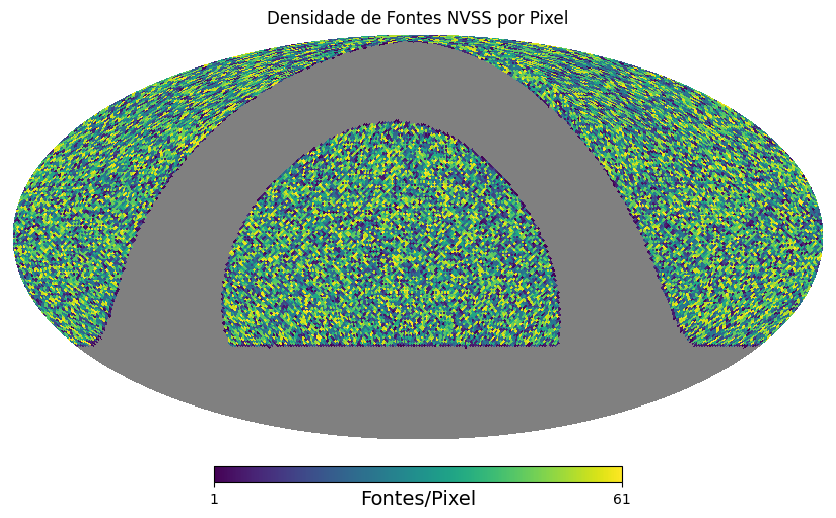

In [15]:
hp.mollview(masked_map,
            title="Densidade de Fontes NVSS por Pixel",
            unit="Fontes/Pixel",
            norm='hist')
plt.show()

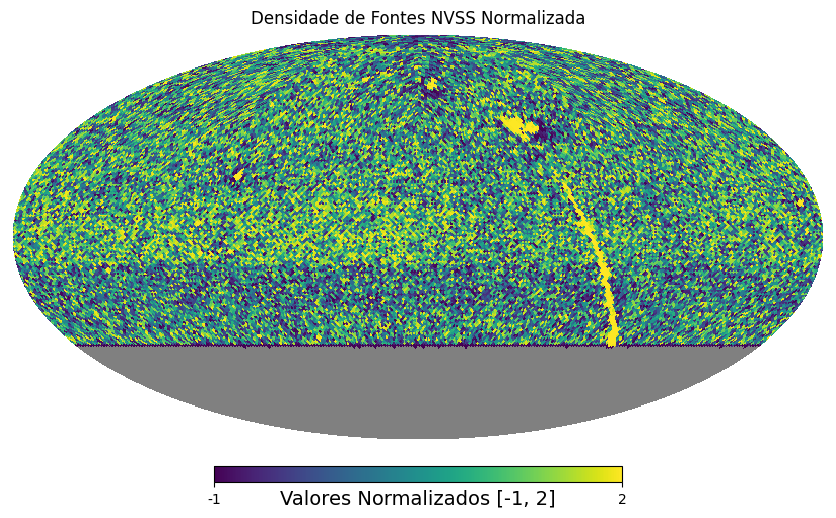

In [16]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importando o catálogo NVSS em CSV
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

# Convertendo RA e DEC para numpy arrays
ra = np.array(nvss['RA'])  # RA
dec = np.array(nvss['DEC'])  # DEC

# Convertendo RA e DEC para ângulos theta e phi em radianos
phi = np.radians(ra)  # RA para phi (em radianos)
theta = np.radians(90.0 - dec)  # DEC para theta (em radianos)

# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

# Convertendo (theta, phi) para índices de pixel HEALPix
pix_indices = hp.ang2pix(nside, theta, phi)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = np.nan  # Usando np.nan para garantir que pixels mascarados não sejam normalizados

# Normalizando os valores no intervalo [-1, 2]
min_val = np.nanmin(masked_map)  # Encontrando o valor mínimo, ignorando np.nan
max_val = np.nanmax(masked_map)  # Encontrando o valor máximo, ignorando np.nan

normalized_map = 3 * (masked_map - min_val) / (max_val - min_val) - 1

# Substituindo os np.nan por hp.UNSEEN após a normalização
normalized_map[np.isnan(normalized_map)] = hp.UNSEEN

# Visualizando o mapa de densidade
hp.mollview(normalized_map, title="Densidade de Fontes NVSS Normalizada", unit="Valores Normalizados [-1, 2]",
            norm='hist')
plt.show()

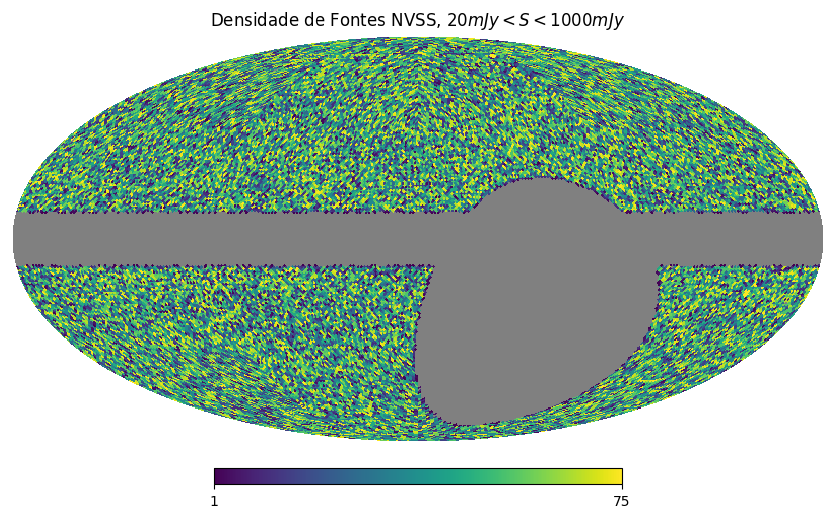

In [17]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importando o catálogo NVSS em CSV
name = r'Densidade de Fontes NVSS, $20mJy <S<1000mJy$'
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-10,10)

data = nvss_flux_20_1000_cut_galac

# Convertendo RA e DEC para numpy arrays
ra = np.array(data['RA'])
dec = np.array(data['DEC'])

# Converter RA e Dec para SkyCoord
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Converter para coordenadas Equatorias p/ galácticas (l, b)
gal_coords = coords.galactic
l = gal_coords.l.deg
b = gal_coords.b.deg

# Convertendo l e b para ângulos theta e phi em radianos
phi = np.radians(l)
theta = np.radians(90.0 - b)

# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

# Convertendo (theta, phi) para índices de pixel HEALPix
pix_indices = hp.ang2pix(nside, theta, phi)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN

# Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()


In [18]:
amp, vec = hp.fit_dipole(masked_map)

# Exibir os resultados do ajuste do dipolo
print("Amplitude do Dipolo:", amp)
print("Direção do Dipolo (vetor):", vec)

Amplitude do Dipolo: 7.8617053144853335
Direção do Dipolo (vetor): [-0.08399668 -0.08730251  0.10422571]


# TGSS

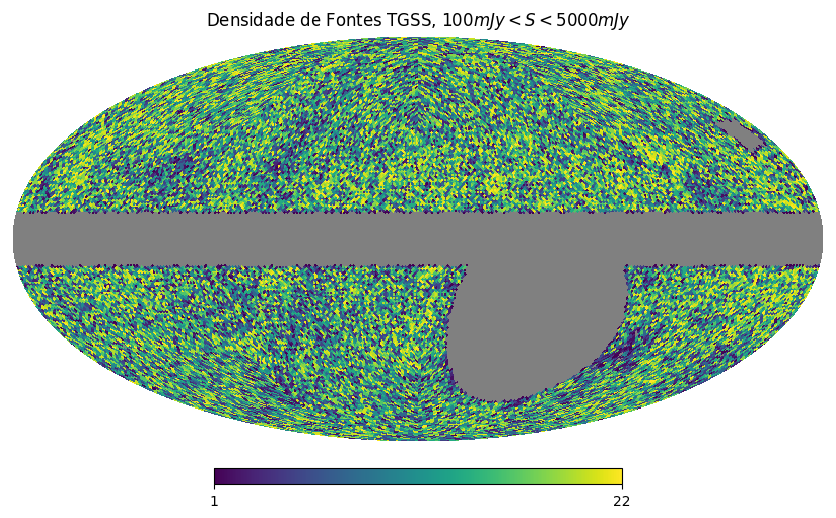

In [19]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importando o catálogo NVSS em CSV

name = r'Densidade de Fontes TGSS, $100mJy <S<5000mJy$'
tgss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /TGSS_coord_flux_Colunas_2_a_7_CSV')

tgss_flux_100_5000 = flux_density_cut(tgss,4,100,5000)
tgss_flux_100_5000_cut_galac = galactic_cut(tgss_flux_100_5000,0,2,-10,10)

data = tgss_flux_100_5000_cut_galac

# Convertendo RA e DEC para numpy arrays
ra = np.array(data['RA'])
dec = np.array(data['DEC'])

# Converter RA e Dec para SkyCoord
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Converter para coordenadas Equatorias p/ galácticas (l, b)
gal_coords = coords.galactic
l = gal_coords.l.deg
b = gal_coords.b.deg

# Convertendo l e b para ângulos theta e phi em radianos
phi = np.radians(l)
theta = np.radians(90.0 - b)

# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

# Convertendo (theta, phi) para índices de pixel HEALPix
pix_indices = hp.ang2pix(nside, theta, phi)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN


# # Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()

# Funções do Estimador do dipolo


In [20]:
# Estimador

@numba.jit
def calculo_delta(coord_ca_cartesian_array, coord_cartesian_array,f_sky):
    f_sky_i = f_sky
    numero_fontes_total = len(coord_ca_cartesian_array)
    sigma_total = numero_fontes_total/(4*np.pi*f_sky)

    delta_list = []
    delta_coord = []

    for x,y,z in coord_cartesian_array:
        up_hemisphere = 0
        down_hemisphere = 0
        for a,b,c in coord_ca_cartesian_array:
            # Se A*B > 0 --->>  Então B é do hemisferio up
            if a*x+b*y+c*z > 0:
                up_hemisphere = up_hemisphere + 1
            # Se A*B < 0 --->>  Então B é do hemisferio down
            if a*x+b*y+c*z < 0:
                down_hemisphere = down_hemisphere + 1

        sigma_up = up_hemisphere/(2*np.pi*f_sky_i)
        sigma_down = down_hemisphere/(2*np.pi*f_sky_i)
        delta = (sigma_up - sigma_down)/sigma_total

        delta_list.append(delta) # adicionar as coordenadas na lista p/ delta
        delta_coord.append([x,y,z]) # adicionar as coordenadas delta

    return delta_list, delta_coord

def estimator(dataframe,coord_cartesian_array,f_sky,ra_index,dec_index):

    # Transformando DataFrame em Numpy Array
    data_array = np.array(dataframe)
    # Pegando as ordenadas Ascenção Reta e Declinação do Array acima
    ra_ca, dec_ca= data_array[:,ra_index] , data_array[:,dec_index]
    # Obtendo coordenadas no Astropy
    c_ca = c_ca = SkyCoord(ra_ca,dec_ca,frame='icrs', unit='deg')
    # Obtendo as coordenadas na forma cartesianas
    a,b,c = c_ca.cartesian.x, c_ca.cartesian.y, c_ca.cartesian.z
    # Transformando as coordenadas cartesianas em arrays separadamente
    a_array,b_array,c_array = np.array(a),np.array(b),np.array(c)
    # Juntando cada array acima na forma colunas em novo array
    coord_ca_cartesian_array = np.stack([a_array,b_array,c_array],axis=1)

    delta_list,delta_coord = calculo_delta(coord_ca_cartesian_array, coord_cartesian_array,f_sky)

    deltas_array = np.array(delta_list).reshape(-1,1)
    deltas_coord = np.array(delta_coord)

    index_min = np.where(deltas_array==deltas_array.min())[0][0]
    index_max = np.where(deltas_array==deltas_array.max())[0][0]

    x_min,y_min,z_min = deltas_coord[index_min][0], deltas_coord[index_min][1], deltas_coord[index_min][2]
    x_max,y_max,z_max = deltas_coord[index_max][0], deltas_coord[index_max][1], deltas_coord[index_max][2]
    # mudando coordenadas para galácticas
    c_min = SkyCoord(x_min, y_min, z_min, representation_type='cartesian')
    c_max = SkyCoord(x_max, y_max, z_max, representation_type='cartesian')

    amp = (deltas_array.min(),deltas_array.max())
    dir = (c_min.galactic.l.value, c_min.galactic.b.value),(c_max.galactic.l.value, c_max.galactic.b.value)

    return amp, dir

## Outras Funções importantes

In [21]:
# Tirando fontes com S em [min,max]
def flux_density_cut(data,column_index,min,max):
    Index = 0
    Index_list = []
    for row in np.array(data):
        S = row[column_index]
        if S<min or S>max:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    data_array = np.array(data)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)
    return new_data

# Elimando fonte que estejam com B em [-b,b]
def galactic_cut(data,RA_column_index,Dec_column_index,Lim_inf,Lim_sup):

    data_array = np.array(data)

    ra_column_array = data_array[:,RA_column_index]
    dec_column_array = data_array[:,Dec_column_index]

    c = SkyCoord(ra_column_array,dec_column_array, frame='icrs', unit='deg')

    b_array = np.array(c.galactic.b)

    Index = 0
    Index_list = []
    for b in b_array:
        if b > Lim_inf  and b < Lim_sup:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)

    return new_data

In [22]:
# Essa funcao transforma coordenadas icrs em coordenadas cartesianas

@numba.njit
def icrs_to_vetor_position(ra, dec):

    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)

    # Construindo o array manualmente
    n = ra.size  # ou len(ra)
    coord_ca_cartesian_array = np.zeros((n, 3), dtype=np.float64)
    coord_ca_cartesian_array[:, 0] = x
    coord_ca_cartesian_array[:, 1] = y
    coord_ca_cartesian_array[:, 2] = z

    return coord_ca_cartesian_array

# Testando estimador para NVSS

In [23]:
# Importando o catálogo NVSS em CSV
name = r'nvss'
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

# Eliminando fontes com S entre 20 mJy e 1000 mJy
nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)

# Eliminando o plano galáctico
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-10,10)

data = nvss_flux_20_1000_cut_galac

In [24]:
quant = len(data)
quant

269307

In [25]:
# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)
npix

49152

In [26]:
# Separando e convertendo RA e DEC para arrays
ra_ca = np.array(data['RA'])
dec_ca = np.array(data['DEC'])

In [27]:
# obtendo as coordenadas cartesianas de cada fontes
ra_ca, dec_ca = np.array(data['RA']), np.array(data['DEC'])

coord_ca_cartesian_array = icrs_to_vetor_position(ra_ca,dec_ca)
coord_ca_cartesian_array

array([[-0.50972082, -0.56955773, -0.64481678],
       [ 0.7642534 ,  0.0116679 , -0.64481051],
       [-0.15150786,  0.74918754, -0.64479717],
       ...,
       [-0.69904254,  0.30907264, -0.64483613],
       [-0.17970074,  0.74289766, -0.64483386],
       [ 0.76003141,  0.08100095, -0.64481865]])

In [28]:
# Criando um array cujos os elementos são os indices dos pixels
ipix = np.arange(npix)
ipix

array([    0,     1,     2, ..., 49149, 49150, 49151])

In [29]:
# Obtendo os angulos dos pixels em coordenadas esféricas padrão em radianos
thetas_pixels, phis_pixels = hp.pix2ang(nside, np.arange(npix))
thetas_pixels, phis_pixels

(array([0.01275785, 0.01275785, 0.01275785, ..., 3.12883481, 3.12883481,
        3.12883481]),
 array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
        5.49778714]))

In [30]:
# obtendo as coordenadas centrais cartesianas de cada pixel
central_pixels_positions = hp.ang2vec(thetas_pixels,phis_pixels)
central_pixels_positions

array([[ 0.00902091,  0.00902091,  0.99991862],
       [-0.00902091,  0.00902091,  0.99991862],
       [-0.00902091, -0.00902091,  0.99991862],
       ...,
       [-0.00902091,  0.00902091, -0.99991862],
       [-0.00902091, -0.00902091, -0.99991862],
       [ 0.00902091, -0.00902091, -0.99991862]])

In [31]:
# convertendo ra e dec p/ angulos em esfericos (theta, phi)
phis_fontes = np.radians(ra_ca)
thetas_fontes = np.radians(90.0 - dec_ca)

In [32]:
# Convertendo (theta, phi) para índices de pixel Healpy
# Também podemos pensar: Qual pixel contém a coordenada (theta, phi) ?

pix_indices = hp.ang2pix(nside, thetas_fontes, phis_fontes)
pix_indices

array([40482, 40320, 40392, ..., 40175, 40393, 40324])

In [33]:
# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)
density_map

array([9, 5, 5, ..., 0, 0, 0])

In [34]:
len(density_map)

49152

In [35]:
np.sum(density_map) # não precisa criar máscara para contar as fontes

269307

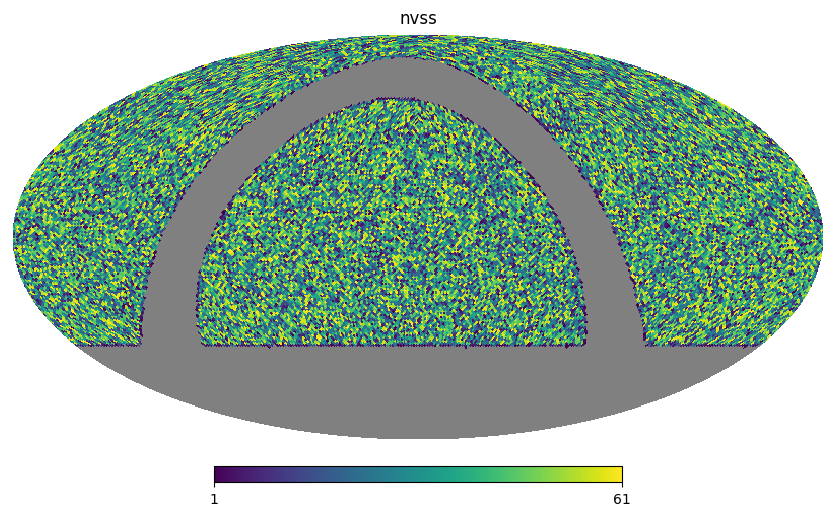

In [36]:
# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN


# # Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()

In [37]:
# Contar quantos pixels não estão vazios
visible_pixels = np.sum(density_map != 0)
visible_pixels

34276

In [38]:
pix_area_sr = hp.nside2pixarea(nside)
pix_area_sr

0.00025566346464760684

In [39]:
# area total do céu
pix_area_sr * npix

12.566370614359172

In [40]:
# area total do céu é igual a area da esfera
pix_area_sr * npix  == 4*np.pi

True

In [41]:
# area restante do céu
remaining_area_sr =  pix_area_sr * visible_pixels
remaining_area_sr

8.763120914261371

In [42]:
# fração do céu disponivel
f_sky = visible_pixels/npix
f_sky

0.6973470052083334

In [43]:
numero_fontes_total = len(coord_ca_cartesian_array)
numero_fontes_total

269307

In [44]:
sigma = numero_fontes_total/(4*np.pi*f_sky)
sigma

30731.859417998156

In [45]:
# costruindo nova função estimador:

@numba.njit
def calculo_delta(coord_ca_cartesian_array, central_pixels_positions ,f_sky):

    delta_list = []
    delta_coord = []

    for x,y,z in central_pixels_positions:
        up_hemisphere = 0
        down_hemisphere = 0
        for a,b,c in coord_ca_cartesian_array:
            # Se A*B > 0 --->>  Então B é do hemisferio up
            if a*x+b*y+c*z > 0:
                up_hemisphere = up_hemisphere + 1
            # Se A*B < 0 --->>  Então B é do hemisferio down
            if a*x+b*y+c*z < 0:
                down_hemisphere = down_hemisphere + 1

        sigma_up = up_hemisphere / (2*np.pi*f_sky)
        sigma_down = down_hemisphere / (2*np.pi*f_sky)
        delta = (sigma_up - sigma_down) / sigma

        delta_list.append(delta) # adicionar as coordenadas na lista p/ delta
        delta_coord.append([x,y,z]) # adicionar as coordenadas delta

    return delta_list, delta_coord

def estimator(coord_ca_cartesian_array, central_pixels_positions,f_sky):

    delta_list,delta_coord = calculo_delta(coord_ca_cartesian_array, central_pixels_positions, f_sky)

    deltas_array = np.array(delta_list).reshape(-1,1)
    deltas_coord = np.array(delta_coord)

    index_min = np.where(deltas_array==deltas_array.min())[0][0]
    index_max = np.where(deltas_array==deltas_array.max())[0][0]

    x_min,y_min,z_min = deltas_coord[index_min][0], deltas_coord[index_min][1], deltas_coord[index_min][2]
    x_max,y_max,z_max = deltas_coord[index_max][0], deltas_coord[index_max][1], deltas_coord[index_max][2]

    # mudando coordenadas para galácticas
    c_min = SkyCoord(x_min, y_min, z_min, representation_type='cartesian')
    c_max = SkyCoord(x_max, y_max, z_max, representation_type='cartesian')

    amp = (deltas_array.min(),deltas_array.max())
    dir = (c_min.galactic.l.value, c_min.galactic.b.value),(c_max.galactic.l.value, c_max.galactic.b.value)

    return amp, dir

In [46]:
delta_list, delta_coord = calculo_delta(coord_ca_cartesian_array, central_pixels_positions ,f_sky)

In [47]:
amp, dir = estimator(coord_ca_cartesian_array, central_pixels_positions, f_sky)
amp, dir

((-0.40755717452572715, 0.40755717452572715),
 ((339.4024455728881, -58.50686381500226),
  (159.40244557288813, 58.50686381500226)))

In [48]:
delta_list, delta_coord = calculo_delta(coord_ca_cartesian_array, central_pixels_positions ,f_sky)

In [49]:
np.array(delta_list).min(), np.array(delta_list).max()

(-0.40755717452572715, 0.40755717452572715)

In [50]:
def sorteio_direcoes_cartisian(x):
    # sorteando 100 direções no céu
    rng = np.random.default_rng()
    ra_random = rng.uniform(0, 360,x)* u.degree
    dec_random = rng.uniform(-90, 90, x)* u.degree
    # Transformando essas direções em coordenadas no Astropy
    coord = SkyCoord(ra_random,dec_random)
    # Obetendo as coordenadas cartesianas das direções
    x,y,z = coord.cartesian.x,coord.cartesian.y,coord.cartesian.z
    # Transformando as coordenadas cartesianas em arrays separadamente
    x_array,y_array,z_array = np.array(x),np.array(y),np.array(z)
    #  Juntando cada array acima na forma de colunas em novo array
    coord_cartesian_array = np.stack([x_array,y_array,z_array],axis=1)
    return coord_cartesian_array

In [51]:
coord_cartesian_array = sorteio_direcoes_cartisian(100_000)

In [52]:
amp, dir = estimator(coord_ca_cartesian_array, coord_cartesian_array, f_sky)
amp, dir

((-0.40786908621016177, 0.4072898216533548),
 ((339.48456094414854, -57.87688177990971),
  (157.88045561647036, 57.265205383280865)))

In [53]:
amp[1]

0.4072898216533548

In [54]:
dir[0][0]

339.48456094414854

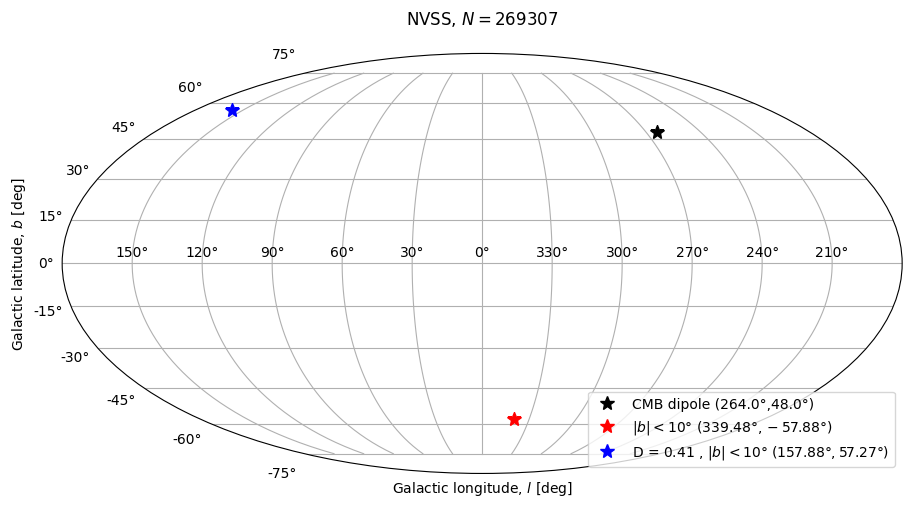

In [55]:
 # Plotagem do Gráfico

co1_10 = SkyCoord(dir[0][0], dir[0][1] , frame='galactic',unit='deg')
co2_10 = SkyCoord(dir[1][0], dir[1][1] , frame='galactic',unit='deg')

co_cmb = SkyCoord(264, 48 , frame='galactic',unit='deg')

l_10 = -co1_10.l.wrap_at(180 * u.deg).radian
b_10 = co1_10.b.radian

l_20 = -co2_10.l.wrap_at(180 * u.deg).radian
b_20 = co2_10.b.radian

l_cmb = -co_cmb.l.wrap_at(180*u.deg).radian
b_cmb = co_cmb.b.radian


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,4.2))
ax = fig.add_subplot(111, projection='mollweide')
#ax.set_xticklabels(['210°', '240°', '270°', '300°', '330°', '0°', '30°', '60°°', '90°', '120°', '150°'])
ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])

#plt.subplot(111, projection="mollweide")
plt.title(rf'NVSS, $N={len(data)}$',y=1.05)

plt.grid(True)

plt.plot(l_cmb,b_cmb,'*', markersize=10, color='black',label=f'CMB dipole ({co_cmb.l.value}°,{co_cmb.b.value}°)')
plt.plot(l_10, b_10,'*', markersize=10, color='red',label=r'$|b|< 10°$ $({:.2f}°,{:.2f}°)$'.format(co1_10.l.value, co1_10.b.value))
plt.plot(l_20, b_20,'*', markersize=10, color='blue',label=r'D = {:.2f} , $|b|< 10°$ $({:.2f}°,{:.2f}°)$'.format(amp[1],co2_10.l.value, co2_10.b.value))

plt.subplots_adjust(top=1,bottom=0)
plt.legend(loc=4)
plt.xlabel('Galactic longitude, $l$ [deg]')
plt.ylabel('Galactic latitude, $b$ [deg]')

plt.show()

In [56]:
# criando máscara simetrica nvss

In [57]:
# Tirando fontes NVSS com DEC específico
def cut(data,Dec_column,dec_min,dec_max):
    Index = 0
    Index_list = []
    for row in np.array(data):
        dec = row[Dec_column]
        if dec>dec_max:
            Index_list.append(Index)
        if dec<dec_min:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    data_array = np.array(data)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)
    return new_data

In [58]:
# Importando o catálogo NVSS em CSV
name = r'nvss'
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

# Eliminando fontes com S entre 20 mJy e 1000 mJy
nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)

# Eliminando o plano galáctico
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-10,10)

# Corte em dec para deixar o catalogo simétrico
nvss_cut_dec = cut(nvss_flux_20_1000_cut_galac,1,-40,40)

data = nvss_cut_dec

In [59]:
quant = len(data)
quant

215624

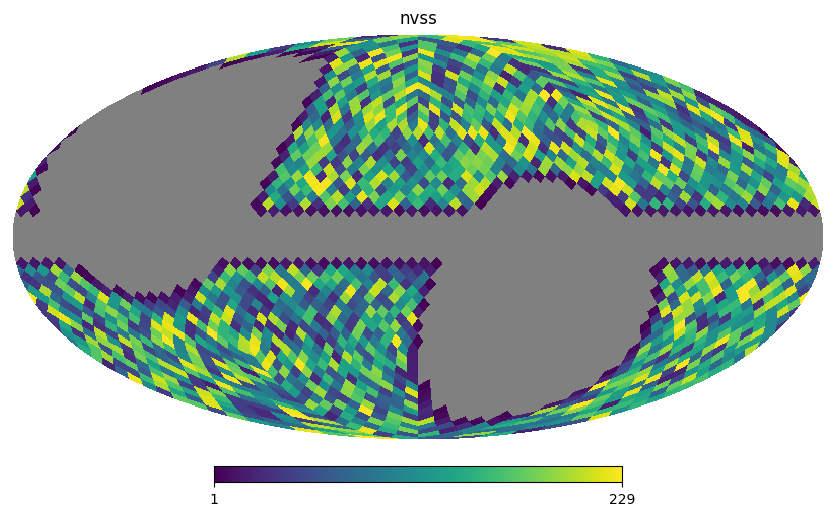

In [60]:
# Convertendo RA e DEC para numpy arrays
ra = np.array(data['RA'])
dec = np.array(data['DEC'])

# Converter RA e Dec para SkyCoord
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Converter para coordenadas Equatorias p/ galácticas (l, b)
gal_coords = coords.galactic
l = gal_coords.l.deg
b = gal_coords.b.deg

# Convertendo l e b para ângulos theta e phi em radianos
phi = np.radians(l)
theta = np.radians(90.0 - b)

# Definindo o NSIDE e calculando o número de pixels
nside = 16
npix = hp.nside2npix(nside)

# Convertendo (theta, phi) para índices de pixel HEALPix
pix_indices = hp.ang2pix(nside, theta, phi)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN


# # Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()

In [61]:
# Separando e convertendo RA e DEC para arrays
ra_ca = np.array(data['RA'])
dec_ca = np.array(data['DEC'])

# obtendo as coordenadas cartesianas de cada fontes
ra_ca, dec_ca = np.array(data['RA']), np.array(data['DEC'])

coord_ca_cartesian_array = icrs_to_vetor_position(ra_ca,dec_ca)


# convertendo ra e dec p/ angulos em esfericos (theta, phi)
phis_fontes = np.radians(ra_ca)
thetas_fontes = np.radians(90.0 - dec_ca)

# Convertendo (theta, phi) para índices de pixel Healpy
# Também podemos pensar: Qual pixel contém a coordenada (theta, phi) ?
pix_indices = hp.ang2pix(nside, thetas_fontes, phis_fontes)


# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)


# Contar quantos pixels não estão vazios
visible_pixels = np.sum(density_map != 0)


# fração do céu disponivel
f_sky = visible_pixels/npix

numero_fontes_total = len(coord_ca_cartesian_array)

sigma_total = numero_fontes_total/(4*np.pi*f_sky)


In [62]:
amp, dir = estimator(coord_ca_cartesian_array, central_pixels_positions, f_sky)
amp, dir

((-0.026450257221430785, 0.026450257221430785),
 ((73.30307549761477, -27.38963093886075),
  (253.30307549761483, 27.389630938860787)))

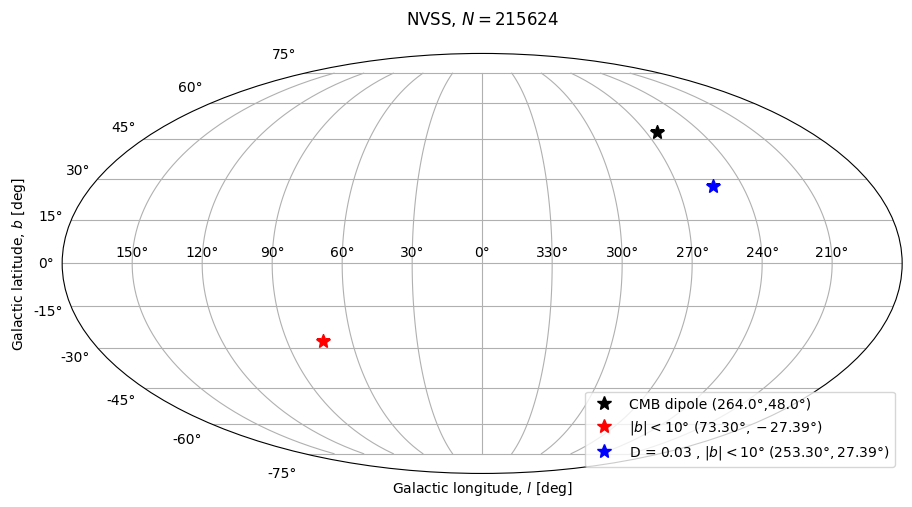

In [63]:
# # Plotagem do Gráfico

co1_10 = SkyCoord(dir[0][0], dir[0][1] , frame='galactic',unit='deg')
co2_10 = SkyCoord(dir[1][0], dir[1][1] , frame='galactic',unit='deg')

co_cmb = SkyCoord(264, 48 , frame='galactic',unit='deg')

l_10 = -co1_10.l.wrap_at(180 * u.deg).radian
b_10 = co1_10.b.radian

l_20 = -co2_10.l.wrap_at(180 * u.deg).radian
b_20 = co2_10.b.radian

l_cmb = -co_cmb.l.wrap_at(180*u.deg).radian
b_cmb = co_cmb.b.radian


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,4.2))
ax = fig.add_subplot(111, projection='mollweide')
#ax.set_xticklabels(['210°', '240°', '270°', '300°', '330°', '0°', '30°', '60°°', '90°', '120°', '150°'])
ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])

#plt.subplot(111, projection="mollweide")
plt.title(rf'NVSS, $N={len(data)}$',y=1.05)

plt.grid(True)

plt.plot(l_cmb,b_cmb,'*', markersize=10, color='black',label=f'CMB dipole ({co_cmb.l.value}°,{co_cmb.b.value}°)')
plt.plot(l_10, b_10,'*', markersize=10, color='red',label=r'$|b|< 10°$ $({:.2f}°,{:.2f}°)$'.format(co1_10.l.value, co1_10.b.value))
plt.plot(l_20, b_20,'*', markersize=10, color='blue',label=r'D = {:.2f} , $|b|< 10°$ $({:.2f}°,{:.2f}°)$'.format(amp[1],co2_10.l.value, co2_10.b.value))

plt.subplots_adjust(top=1,bottom=0)
plt.legend(loc=4)
plt.xlabel('Galactic longitude, $l$ [deg]')
plt.ylabel('Galactic latitude, $b$ [deg]')

plt.show()

In [64]:
# tentando de novo

In [88]:
# Importando o catálogo NVSS em CSV
name = r'nvss'
nvss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Densidade de fontes Healpy /NVSS_Catalog_CSV')

# Eliminando fontes com S entre 20 mJy e 1000 mJy
nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)

# Eliminando o plano galáctico
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-20,20)

data = nvss_flux_20_1000_cut_galac

In [92]:
# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

#       1 - Coordenadas cartesianas das fontes e dos pixels
#-------------------------------------------------------------------------------

# Obtendo os angulos dos pixels em coordenadas esféricas padrão em radianos
thetas_pixels, phis_pixels = hp.pix2ang(nside, np.arange(npix))

# obtendo as coordenadas centrais cartesianas de cada pixel
central_pixels_positions = hp.ang2vec(thetas_pixels,phis_pixels)


# obtendo as coordenadas cartesianas de cada fontes
ra_ca, dec_ca = np.array(data['RA']), np.array(data['DEC'])
coord_ca_cartesian_array = icrs_to_vetor_position(ra_ca,dec_ca)
#-------------------------------------------------------------------------------


#                     2 - Mapa de densidade
#-------------------------------------------------------------------------------

# convertendo ra e dec p/ angulos em esfericos (theta, phi)
phis_fontes = np.radians(ra_ca)
thetas_fontes = np.radians(90.0 - dec_ca)

# Convertendo (theta, phi) das fontes para índices de pixel Healpy
# Também podemos pensar: Qual pixel contém a coordenada (theta, phi) ?
pix_indices = hp.ang2pix(nside, thetas_fontes, phis_fontes)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)
#-------------------------------------------------------------------------------

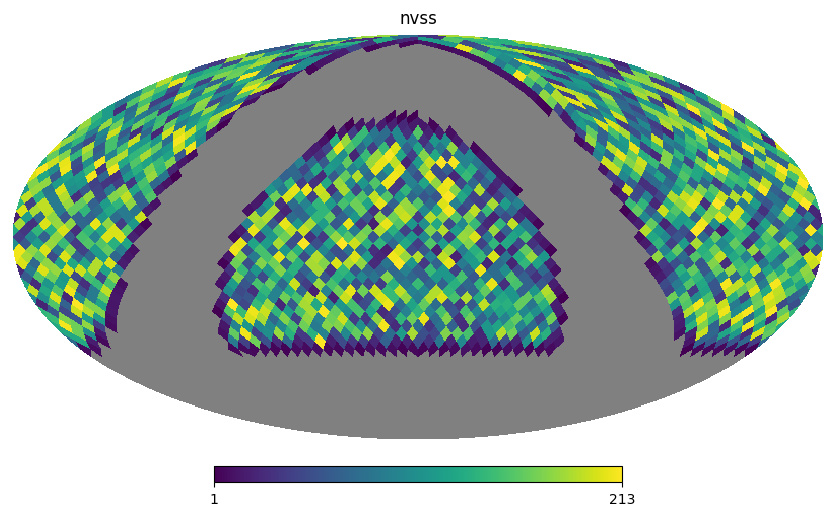

In [93]:
# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN


# # Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()

In [94]:
npix

3072

In [95]:
# Contar quantos pixels não estão vazios
visible_pixels = np.sum(density_map != 0)
visible_pixels

1843

In [96]:
f_sky = visible_pixels/npix
f_sky

0.5999348958333334

In [97]:
sigma = len(coord_ca_cartesian_array) / (4*np.pi*f_sky)
sigma

28890.55277149901

In [98]:
def f_sky_calc(up,down):
  # fração do céu disponivel
  pix_indices = hp.vec2pix(nside, np.array(up)[:,0], np.array(up)[:,1], np.array(up)[:,2])
  # Contando o número de fontes em cada pixel
  density_map = np.bincount(pix_indices, minlength=npix)
  # Contar quantos pixels não estão vazios
  visible_pixels = np.sum(density_map != 0)
  # fração do céu disponivel
  f_sky_up_i = visible_pixels/npix

  down = np.array(down)
  pix_indices = hp.vec2pix(nside, np.array(down)[:,0], np.array(down)[:,1], np.array(down)[:,2])
  # Contando o número de fontes em cada pixel
  density_map = np.bincount(pix_indices, minlength=npix)
  # Contar quantos pixels não estão vazios
  visible_pixels = np.sum(density_map != 0)
  # fração do céu disponivel
  f_sky_down_i = visible_pixels/npix

  return f_sky_up_i, f_sky_down_i

delta_list = np.empty(len(central_pixels_positions), dtype=np.float64)
delta_coord = np.empty((len(central_pixels_positions), 3), dtype=np.float64)

for i in range(len(central_pixels_positions)):

  a, b, c = central_pixels_positions[i]
  dot_products = coord_ca_cartesian_array @ np.array([a, b, c])

  up = coord_ca_cartesian_array[dot_products > 0]
  down = coord_ca_cartesian_array[dot_products < 0]

  f_sky_up_i, f_sky_down_i = f_sky_calc(up,down)

  sigma_up = len(up) / (4*np.pi* f_sky_up_i )
  sigma_down = len(down) / (4*np.pi* f_sky_down_i  )
  delta = (sigma_up - sigma_down) / sigma

  delta_list[i] = delta
  delta_coord[i] = [a, b, c]

In [99]:
# usando a densidade hemisfério com 4*pi*f_sky_i b in [-20,20]
delta_list.min(), delta_list.max()

(-0.08900049408111912, 0.08900049408111912)